# Basic Simulation Run on load_wine() dataset

In [4]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

# Load dataset
data = load_wine()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.2, random_state=42)


In [5]:
from sklearn.ensemble import RandomForestClassifier

# Define the model
model = RandomForestClassifier()

# Define parameter grid
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}


In [8]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, make_scorer

# Define the scorer
scorer = make_scorer(roc_auc_score, multi_class='ovo', needs_proba=True)

# Grid Search
grid_search = GridSearchCV(model, param_grid, scoring=scorer, cv=5)
grid_search.fit(X_train, y_train)
print("Best parameters (Grid Search):", grid_search.best_params_)

# Random Search
random_search = RandomizedSearchCV(model, param_grid, scoring=scorer, cv=5, n_iter=10, random_state=42)
random_search.fit(X_train, y_train)
print("Best parameters (Random Search):", random_search.best_params_)


Best parameters (Grid Search): {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}
Best parameters (Random Search): {'n_estimators': 100, 'min_samples_split': 10, 'max_depth': 30}


In [9]:
import numpy as np
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

# Define the function to be optimized
def black_box_function(params):
    n_estimators, max_depth, min_samples_split = params[0], params[1], params[2]
    model = RandomForestClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth), min_samples_split=int(min_samples_split))
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_test)
    return -roc_auc_score(y_test, preds, multi_class='ovo')  # Negative because we minimize in optimization

# Bayesian Optimization
class BayesianOptimization:
    def __init__(self, func, bounds, n_iter=25, kernel=None):
        self.func = func
        self.bounds = bounds
        self.n_iter = n_iter
        self.kernel = kernel or Matern()
        self.gp = GaussianProcessRegressor(kernel=self.kernel)
        self.x_samples = []
        self.y_samples = []

    def propose_location(self, acquisition_func):
        x_candidates = np.random.uniform(self.bounds[:, 0], self.bounds[:, 1], size=(1000, self.bounds.shape[0]))
        acquisition_values = acquisition_func(x_candidates)
        return x_candidates[np.argmax(acquisition_values)].reshape(1, -1)

    def optimize(self):
        for _ in range(self.n_iter):
            if len(self.x_samples) > 0:
                self.gp.fit(np.array(self.x_samples), np.array(self.y_samples))
                x_next = self.propose_location(self.expected_improvement)
            else:
                x_next = np.random.uniform(self.bounds[:, 0], self.bounds[:, 1], size=(1, self.bounds.shape[0]))

            y_next = self.func(x_next[0])
            self.x_samples.append(x_next[0])
            self.y_samples.append(y_next)

        return self.x_samples, self.y_samples

    def expected_improvement(self, x, xi=0.01):
        mu, sigma = self.gp.predict(x, return_std=True)
        mu_sample_opt = np.min(self.y_samples)

        with np.errstate(divide='warn'):
            imp = mu_sample_opt - mu - xi
            Z = imp / sigma
            ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
            ei[sigma == 0.0] = 0.0

        return ei

# Define the bounds of the search space
bounds = np.array([[10, 100], [1, 30], [2, 10]])

# Perform Bayesian optimization
bo = BayesianOptimization(black_box_function, bounds)
x_samples, y_samples = bo.optimize()
best_params = x_samples[np.argmin(y_samples)]
print("Best parameters (Bayesian Optimization):", best_params)


Best parameters (Bayesian Optimization): [10.65621301 10.94903505  3.14265882]


In [10]:
from sklearn.model_selection import cross_val_score

# Evaluate Grid Search Model
grid_model = grid_search.best_estimator_
grid_auc = cross_val_score(grid_model, X_train, y_train, cv=5, scoring=scorer)
print("Grid Search AUC:", grid_auc.mean())

# Evaluate Random Search Model
random_model = random_search.best_estimator_
random_auc = cross_val_score(random_model, X_train, y_train, cv=5, scoring=scorer)
print("Random Search AUC:", random_auc.mean())

# Evaluate Bayesian Optimization Model
bo_model = RandomForestClassifier(n_estimators=int(best_params[0]), max_depth=int(best_params[1]), min_samples_split=int(best_params[2]))
bo_model.fit(X_train, y_train)
bo_preds = bo_model.predict_proba(X_test)
bo_auc = roc_auc_score(y_test, bo_preds, multi_class='ovo')
print("Bayesian Optimization AUC:", bo_auc)


Grid Search AUC: 0.9996632996632997
Random Search AUC: 0.9996632996632997
Bayesian Optimization AUC: 0.9991496598639457


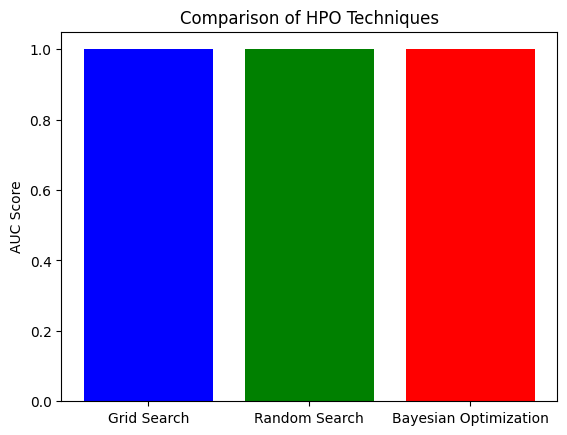

In [11]:
import matplotlib.pyplot as plt

# Plot AUC Scores
methods = ['Grid Search', 'Random Search', 'Bayesian Optimization']
auc_scores = [grid_auc.mean(), random_auc.mean(), bo_auc]

plt.bar(methods, auc_scores, color=['blue', 'green', 'red'])
plt.ylabel('AUC Score')
plt.title('Comparison of HPO Techniques')
plt.show()


In [12]:
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import norm
import numpy as np

class RandomForestOptimization:
    def __init__(self, func, bounds, n_iter=25):
        self.func = func
        self.bounds = bounds
        self.n_iter = n_iter
        self.rf = RandomForestRegressor()
        self.x_samples = []
        self.y_samples = []

    def propose_location(self):
        x_candidates = np.random.uniform(self.bounds[:, 0], self.bounds[:, 1], size=(1000, self.bounds.shape[0]))
        y_preds = self.rf.predict(x_candidates)
        return x_candidates[np.argmax(y_preds)].reshape(1, -1)

    def optimize(self):
        for _ in range(self.n_iter):
            if len(self.x_samples) > 0:
                self.rf.fit(np.array(self.x_samples), np.array(self.y_samples))
                x_next = self.propose_location()
            else:
                x_next = np.random.uniform(self.bounds[:, 0], self.bounds[:, 1], size=(1, self.bounds.shape[0]))

            y_next = self.func(x_next[0])
            self.x_samples.append(x_next[0])
            self.y_samples.append(y_next)

        return self.x_samples, self.y_samples

# Perform Random Forest Optimization
rfo = RandomForestOptimization(black_box_function, bounds)
x_samples_rfo, y_samples_rfo = rfo.optimize()
best_params_rfo = x_samples_rfo[np.argmin(y_samples_rfo)]
print("Best parameters (Random Forest Optimization):", best_params_rfo)


Best parameters (Random Forest Optimization): [83.36057207 15.63940939  6.60246544]


In [14]:
import numpy as np
from scipy.stats import norm

class TPEOptimization:
    def __init__(self, func, bounds, n_iter=25, gamma=0.25, bandwidth=0.1):
        self.func = func
        self.bounds = bounds
        self.n_iter = n_iter
        self.gamma = gamma
        self.bandwidth = bandwidth
        self.x_samples = []
        self.y_samples = []

    def parzen_window(self, samples, x):
        return np.mean([norm.pdf(x, loc=sample, scale=self.bandwidth) for sample in samples])

    def suggest(self):
        if len(self.y_samples) < 1:
            return np.random.uniform(self.bounds[:, 0], self.bounds[:, 1], size=self.bounds.shape[0])

        n_good = int(np.ceil(self.gamma * len(self.y_samples)))
        y_sorted_indices = np.argsort(self.y_samples)
        good_samples = [self.x_samples[i] for i in y_sorted_indices[:n_good]]
        bad_samples = [self.x_samples[i] for i in y_sorted_indices[n_good:]]

        x_new = []
        for dim in range(self.bounds.shape[0]):
            x_candidates = np.linspace(self.bounds[dim, 0], self.bounds[dim, 1], 100)
            good_likelihood = np.array([self.parzen_window([sample[dim] for sample in good_samples], x_dim) for x_dim in x_candidates])
            bad_likelihood = np.array([self.parzen_window([sample[dim] for sample in bad_samples], x_dim) for x_dim in x_candidates])

            # To avoid division by zero, add a small value (epsilon) to bad_likelihood
            epsilon = 1e-8
            likelihood_ratio = np.log(good_likelihood + epsilon) - np.log(bad_likelihood + epsilon)

            x_new.append(x_candidates[np.argmax(likelihood_ratio)])

        return np.array(x_new)

    def optimize(self):
        for _ in range(self.n_iter):
            x_next = self.suggest()
            y_next = self.func(x_next)
            self.x_samples.append(x_next)
            self.y_samples.append(y_next)

        return self.x_samples, self.y_samples

# Perform TPE Optimization
tpe = TPEOptimization(black_box_function, bounds)
x_samples_tpe, y_samples_tpe = tpe.optimize()
best_params_tpe = x_samples_tpe[np.argmin(y_samples_tpe)]
print("Best parameters (TPE):", best_params_tpe)


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Best parameters (TPE): [48.11342726 22.90458918  8.62661435]


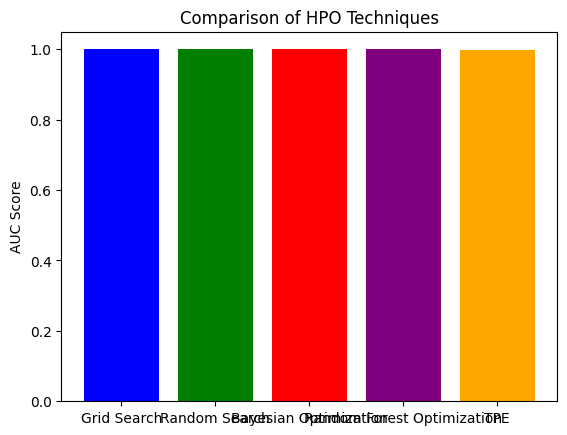

In [17]:
def evaluate_model(params):
    n_estimators = int(params[0])
    max_depth = params[1] if params[1] is None else int(params[1])
    min_samples_split = int(params[2])

    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split)
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_test)
    return roc_auc_score(y_test, preds, multi_class='ovo')

# Evaluate models
grid_auc = evaluate_model([best_params_grid['n_estimators'], best_params_grid['max_depth'], best_params_grid['min_samples_split']])
random_auc = evaluate_model([best_params_random['n_estimators'], best_params_random['max_depth'], best_params_random['min_samples_split']])
bo_auc = evaluate_model(best_params_bo)
rfo_auc = evaluate_model(best_params_rfo)
tpe_auc = evaluate_model(best_params_tpe)

# Compare the Results
methods = ['Grid Search', 'Random Search', 'Bayesian Optimization', 'Random Forest Optimization', 'TPE']
auc_scores = [grid_auc, random_auc, bo_auc, rfo_auc, tpe_auc]

plt.bar(methods, auc_scores, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.ylabel('AUC Score')
plt.title('Comparison of HPO Techniques')
plt.show()


# GridSearch + RandomizedSearch Technique
 Over a fairly simple dataset

> Grid Search;
> Random Search;
> Pipeline for Random Search with PCA Decomposition;





In [26]:
import pandas as pd
import numpy as np

from sklearn import ensemble
from sklearn import metrics
from sklearn import model_selection #cross validation

if __name__ == "__main__":
    df = pd.read_csv("/content/mobile_train.csv")
    print(df.columns) # Corrected the path to be a string
    X = df.drop("price_range", axis=1).values
    Y = df.price_range.values

    classifier = ensemble.RandomForestClassifier(n_jobs=-1)
    param_grid = {
        "n_estimators": [100, 200, 300, 400],
        "max_depth": [1, 3, 5, 7],
        "criterion": ["gini", "entropy"]
    }

    model = model_selection.GridSearchCV(
        estimator=classifier,
        param_grid=param_grid,
        scoring="accuracy",
        verbose=10,
        n_jobs=1,
        cv=5
    )
    model.fit(X, Y)


Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi', 'price_range'],
      dtype='object')
Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5; 1/32] START criterion=gini, max_depth=1, n_estimators=100..............
[CV 1/5; 1/32] END criterion=gini, max_depth=1, n_estimators=100;, score=0.595 total time=   0.4s
[CV 2/5; 1/32] START criterion=gini, max_depth=1, n_estimators=100..............
[CV 2/5; 1/32] END criterion=gini, max_depth=1, n_estimators=100;, score=0.632 total time=   0.3s
[CV 3/5; 1/32] START criterion=gini, max_depth=1, n_estimators=100..............
[CV 3/5; 1/32] END criterion=gini, max_depth=1, n_estimators=100;, score=0.625 total time=   0.2s
[CV 4/5; 1/32] START criterion=gini, max_depth=1, n_estimators=100..............
[CV 4/5; 1/32] END criterion=gini, ma

In [27]:
print(model.best_score_)
print(model.best_estimator_.get_params())

0.8695
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 7, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [29]:
import pandas as pd
import numpy as np

from sklearn import ensemble
from sklearn import metrics
from sklearn import model_selection #cross validation

if __name__ == "__main__":
    df = pd.read_csv("/content/mobile_train.csv")
    print(df.columns) # Corrected the path to be a string
    X = df.drop("price_range", axis=1).values
    Y = df.price_range.values

    classifier = ensemble.RandomForestClassifier(n_jobs=-1)
    param_grid = {
        "n_estimators": np.arange(100,1500,100),
        "max_depth":  np.arange(1, 20),
        "criterion": ["gini", "entropy"]
    }

    model = model_selection.RandomizedSearchCV(
        estimator=classifier,
        param_distributions=param_grid,
        n_iter=10,
        scoring="accuracy",
        verbose=10,
        n_jobs=1,
        cv=5
    )
    model.fit(X, Y)
    print(model.best_score_)
    print(model.best_estimator_.get_params())


Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi', 'price_range'],
      dtype='object')
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START criterion=entropy, max_depth=16, n_estimators=1200.........
[CV 1/5; 1/10] END criterion=entropy, max_depth=16, n_estimators=1200;, score=0.887 total time=   5.2s
[CV 2/5; 1/10] START criterion=entropy, max_depth=16, n_estimators=1200.........
[CV 2/5; 1/10] END criterion=entropy, max_depth=16, n_estimators=1200;, score=0.892 total time=   6.5s
[CV 3/5; 1/10] START criterion=entropy, max_depth=16, n_estimators=1200.........
[CV 3/5; 1/10] END criterion=entropy, max_depth=16, n_estimators=1200;, score=0.902 total time=   5.1s
[CV 4/5; 1/10] START criterion=entropy, max_depth=16, n_estimators=1200.........
[CV 4/5; 1/10] END crit

In [30]:
import pandas as pd
import numpy as np

from sklearn import ensemble
from sklearn import metrics
from sklearn import model_selection #cross validation
from sklearn import decomposition
from sklearn import preprocessing
from sklearn import pipeline

if __name__ == "__main__":
    df = pd.read_csv("/content/mobile_train.csv")
    print(df.columns) # Corrected the path to be a string
    X = df.drop("price_range", axis=1).values
    Y = df.price_range.values

    scl = preprocessing.StandardScaler()
    pca = decomposition.PCA()
    rf = ensemble.RandomForestClassifier(n_jobs=-1)

    classifier = pipeline.Pipeline([
        ("scaling", scl),
        ("pca", pca),
        ("rf", rf)
    ])

    param_grid = {
        "pca__n_components" : np.arange(5,10),
        "rf__n_estimators": np.arange(100,1500,100),
        "rf__max_depth":  np.arange(1, 20),
        "rf__criterion": ["gini", "entropy"]
    }

    model = model_selection.RandomizedSearchCV(
        estimator=classifier,
        param_distributions=param_grid,
        n_iter=10,
        scoring="accuracy",
        verbose=10,
        n_jobs=1,
        cv=5
    )
    model.fit(X, Y)
    print(model.best_score_)
    print(model.best_estimator_.get_params())


Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi', 'price_range'],
      dtype='object')
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START pca__n_components=8, rf__criterion=gini, rf__max_depth=14, rf__n_estimators=100
[CV 1/5; 1/10] END pca__n_components=8, rf__criterion=gini, rf__max_depth=14, rf__n_estimators=100;, score=0.380 total time=   0.9s
[CV 2/5; 1/10] START pca__n_components=8, rf__criterion=gini, rf__max_depth=14, rf__n_estimators=100
[CV 2/5; 1/10] END pca__n_components=8, rf__criterion=gini, rf__max_depth=14, rf__n_estimators=100;, score=0.403 total time=   0.8s
[CV 3/5; 1/10] START pca__n_components=8, rf__criterion=gini, rf__max_depth=14, rf__n_estimators=100
[CV 3/5; 1/10] END pca__n_components=8, rf__criterion=gini, rf__max_depth=14, rf__n_estim

Columns in the dataset: Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi', 'price_range'],
      dtype='object')
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best ROC AUC score: 0.7282016666666666
Best estimator parameters: {'memory': None, 'steps': [('scaling', StandardScaler()), ('pca', PCA(n_components=9)), ('rf', RandomForestClassifier(max_depth=8, n_estimators=1400, n_jobs=-1))], 'verbose': False, 'scaling': StandardScaler(), 'pca': PCA(n_components=9), 'rf': RandomForestClassifier(max_depth=8, n_estimators=1400, n_jobs=-1), 'scaling__copy': True, 'scaling__with_mean': True, 'scaling__with_std': True, 'pca__copy': True, 'pca__iterated_power': 'auto', 'pca__n_components': 9, 'pca__n_oversamples': 10, 'pca__power_iteration_normalizer': 'auto', 'pca__random_state': None, 'pca__

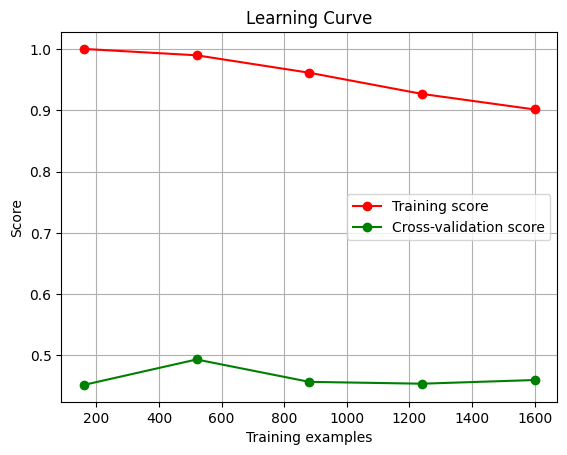

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn import metrics
from sklearn import model_selection
from sklearn import decomposition
from sklearn import preprocessing
from sklearn import pipeline
from sklearn.metrics import roc_auc_score, make_scorer

# Custom scorer using ROC AUC
def custom_roc_auc(y_true, y_pred):
    return roc_auc_score(y_true, y_pred, multi_class='ovo', average='macro')

roc_auc_scorer = make_scorer(custom_roc_auc, needs_proba=True)

if __name__ == "__main__":
    df = pd.read_csv("/content/mobile_train.csv")
    print("Columns in the dataset:", df.columns)

    X = df.drop("price_range", axis=1).values
    Y = df["price_range"].values

    scl = preprocessing.StandardScaler()
    pca = decomposition.PCA()
    rf = ensemble.RandomForestClassifier(n_jobs=-1)

    classifier = pipeline.Pipeline([
        ("scaling", scl),
        ("pca", pca),
        ("rf", rf)
    ])

    param_grid = {
        "pca__n_components": np.arange(5, 10),
        "rf__n_estimators": np.arange(100, 1500, 100),
        "rf__max_depth": np.arange(1, 20),
        "rf__criterion": ["gini", "entropy"]
    }

    model = model_selection.RandomizedSearchCV(
        estimator=classifier,
        param_distributions=param_grid,
        n_iter=10,
        scoring=roc_auc_scorer,
        verbose=10,
        n_jobs=-1,
        cv=5
    )
    model.fit(X, Y)

    print("Best ROC AUC score:", model.best_score_)
    print("Best estimator parameters:", model.best_estimator_.get_params())

    # Plot learning curve for the best model
    def plot_learning_curve(estimator, X, y, cv=5, n_jobs=-1, scoring='accuracy'):
        train_sizes, train_scores, test_scores = model_selection.learning_curve(
            estimator, X, y, cv=cv, n_jobs=n_jobs, scoring=scoring)

        train_scores_mean = np.mean(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)

        plt.figure()
        plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label="Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label="Cross-validation score")
        plt.title('Learning Curve')
        plt.xlabel('Training examples')
        plt.ylabel('Score')
        plt.legend(loc='best')
        plt.grid()
        plt.show()

    best_estimator = model.best_estimator_
    plot_learning_curve(best_estimator, X, Y, cv=5, scoring='accuracy')


# Bayesian Optimization with Gaussian Process

In [4]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 1.9 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np

from sklearn import ensemble
from sklearn import metrics
from sklearn import model_selection # cross validation
from skopt import space
from skopt import gp_minimize
from functools import partial

# Optimization function
def optimize(params, param_names, x, y):
    params = dict(zip(param_names, params))
    model = ensemble.RandomForestClassifier(**params)
    kf = model_selection.StratifiedKFold(n_splits=5)
    accuracies = []

    for train_idx, test_idx in kf.split(X=x, y=y):
        xtrain = x[train_idx]
        ytrain = y[train_idx]
        xtest = x[test_idx]
        ytest = y[test_idx]

        model.fit(xtrain, ytrain)
        preds = model.predict(xtest)
        fold_acc = metrics.accuracy_score(ytest, preds)
        accuracies.append(fold_acc)

    # Return the negative accuracy to minimize
    return -1.0 * np.mean(accuracies)

if __name__ == "__main__":
    df = pd.read_csv("/content/mobile_train.csv")
    print("Columns in the dataset:", df.columns)
    X = df.drop("price_range", axis=1).values
    Y = df["price_range"].values

    param_space = [
        space.Integer(3, 15, name="max_depth"),
        space.Integer(100, 600, name="n_estimators"),
        space.Categorical(["gini", "entropy"], name="criterion"),
        space.Real(0.01, 1, prior="uniform", name="max_features")
    ]

    param_names = ["max_depth", "n_estimators", "criterion", "max_features"]

    optimization_function = partial(
        optimize,
        param_names=param_names,
        x=X,
        y=Y
    )

    result = gp_minimize(
        optimization_function,
        dimensions=param_space,
        n_calls=50,  # number of evaluations of minimize
        n_random_starts=10,
        verbose=True
    )

    print("Best Parameters:", dict(zip(param_names, result.x)))
    print("Best Score:", -result.fun)


Columns in the dataset: Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi', 'price_range'],
      dtype='object')
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 30.5667
Function value obtained: -0.8640
Current minimum: -0.8640
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 5.7398
Function value obtained: -0.8790
Current minimum: -0.8790
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 5.9859
Function value obtained: -0.7120
Current minimum: -0.8790
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at ran

# HyperOpt Simulation



> Just for learning!







In [6]:
import pandas as pd
import numpy as np

from sklearn import ensemble
from sklearn import metrics
from sklearn import model_selection # cross validation
from skopt import space
from skopt import gp_minimize
from functools import partial

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from hyperopt.pyll.base import scope

# Optimization function
def optimize(params, x, y):
    model = ensemble.RandomForestClassifier(**params)
    kf = model_selection.StratifiedKFold(n_splits=5)
    accuracies = []

    for train_idx, test_idx in kf.split(X=x, y=y):
        xtrain = x[train_idx]
        ytrain = y[train_idx]
        xtest = x[test_idx]
        ytest = y[test_idx]

        model.fit(xtrain, ytrain)
        preds = model.predict(xtest)
        fold_acc = metrics.accuracy_score(ytest, preds)
        accuracies.append(fold_acc)

    # Return the negative accuracy to minimize
    return -1.0 * np.mean(accuracies)

if __name__ == "__main__":
    df = pd.read_csv("/content/mobile_train.csv")
    print("Columns in the dataset:", df.columns)
    X = df.drop("price_range", axis=1).values
    Y = df["price_range"].values

    param_space = {
        "max_depth" : scope.int(hp.quniform("max_depth", 3, 15, 1)),
        "n_estimators" : scope.int(hp.quniform("n_estimators", 100, 600, 1)),
        "criterion" : hp.choice("criterion", ["gini", "entropy"]),
        "max_features" : hp.uniform("max_features", 0.01, 1)
    }

    # param_names = ["max_depth", "n_estimators", "criterion", "max_features"]

    optimization_function = partial(
        optimize,
        x=X,
        y=Y
    )

    trials = Trials()
    # best_params = fmin(fn=optimization_function, space=param_space, algo=tpe.suggest, max_evals=50, trials=trials)

    result = fmin(
        fn=optimization_function,
        space=param_space,
        algo = tpe.suggest,
        max_evals=20,
        trials=trials
    )

    print(result)


Columns in the dataset: Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi', 'price_range'],
      dtype='object')
100%|██████████| 20/20 [03:26<00:00, 10.30s/trial, best loss: -0.9075]
{'criterion': 1, 'max_depth': 11.0, 'max_features': 0.7850101125354382, 'n_estimators': 322.0}


# Using Optuna

In [8]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.1 MB/s eta 0:00:00


In [11]:
import pandas as pd
import numpy as np

from sklearn import ensemble
from sklearn import metrics
from sklearn import model_selection # cross validation
import optuna
from functools import partial

# Optimization function for Optuna
def optimize_optuna(trial, x, y):
    entropy = trial.suggest_categorical("criterion", ["gini", "entropy"])
    n_estimators = trial.suggest_int("n_estimators", 100, 1500)
    max_depth = trial.suggest_int("max_depth", 3, 15)
    max_features = trial.suggest_float("max_features", 0.01, 1.0)

    model = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        criterion=entropy
    )
    kf = model_selection.StratifiedKFold(n_splits=5)
    accuracies = []

    for train_idx, test_idx in kf.split(X=x, y=y):
        xtrain = x[train_idx]
        ytrain = y[train_idx]
        xtest = x[test_idx]
        ytest = y[test_idx]

        model.fit(xtrain, ytrain)
        preds = model.predict(xtest)
        fold_acc = metrics.accuracy_score(ytest, preds)
        accuracies.append(fold_acc)

    # Return the negative accuracy to minimize
    return -1.0 * np.mean(accuracies)

if __name__ == "__main__":
    df = pd.read_csv("/content/mobile_train.csv")
    print("Columns in the dataset:", df.columns)
    X = df.drop("price_range", axis=1).values
    Y = df["price_range"].values

    optimization_function = partial(optimize_optuna, x=X, y=Y)
    study = optuna.create_study(direction="minimize")
    study.optimize(optimization_function, n_trials=15)

    print("Best Parameters from Optuna:", study.best_params)
    print("Best Score from Optuna:", -study.best_value)


[I 2024-06-17 14:25:25,024] A new study created in memory with name: no-name-6341b45d-ef2b-4b21-a0ff-5d0f180bc1ad


Columns in the dataset: Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi', 'price_range'],
      dtype='object')


[I 2024-06-17 14:25:51,520] Trial 0 finished with value: -0.8979999999999999 and parameters: {'criterion': 'entropy', 'n_estimators': 667, 'max_depth': 8, 'max_features': 0.44821478068801335}. Best is trial 0 with value: -0.8979999999999999.
[I 2024-06-17 14:26:35,166] Trial 1 finished with value: -0.8620000000000001 and parameters: {'criterion': 'entropy', 'n_estimators': 1239, 'max_depth': 5, 'max_features': 0.4052983234113337}. Best is trial 0 with value: -0.8979999999999999.
[I 2024-06-17 14:26:38,803] Trial 2 finished with value: -0.783 and parameters: {'criterion': 'entropy', 'n_estimators': 276, 'max_depth': 6, 'max_features': 0.1367661335772863}. Best is trial 0 with value: -0.8979999999999999.
[I 2024-06-17 14:27:34,553] Trial 3 finished with value: -0.906 and parameters: {'criterion': 'entropy', 'n_estimators': 1433, 'max_depth': 14, 'max_features': 0.5101682638781552}. Best is trial 3 with value: -0.906.
[I 2024-06-17 14:27:57,117] Trial 4 finished with value: -0.8695 and pa

Best Parameters from Optuna: {'criterion': 'entropy', 'n_estimators': 1022, 'max_depth': 15, 'max_features': 0.7462773758672738}
Best Score from Optuna: 0.9105000000000001


In [16]:
import pandas as pd
import numpy as np
from sklearn import ensemble, metrics, model_selection
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from functools import partial

def plot_learning_curve(estimator, X, y, title="Learning Curve", cv=5, n_jobs=-1):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, scoring="roc_auc_ovr"
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)

    plt.grid()

    plt.fill_between(
        train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r"
    )
    plt.fill_between(
        train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g"
    )

    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt


Columns in the dataset: Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi', 'price_range'],
      dtype='object')
100%|██████████| 20/20 [12:16<00:00, 36.85s/trial, best loss: -0.9899958333333334]
Best Parameters from Hyperopt: {'criterion': 'entropy', 'n_estimators': 1298, 'max_depth': 11, 'max_features': 0.8407222083891507}


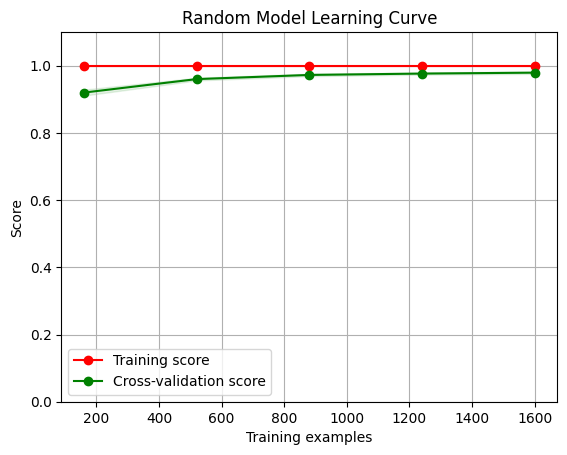

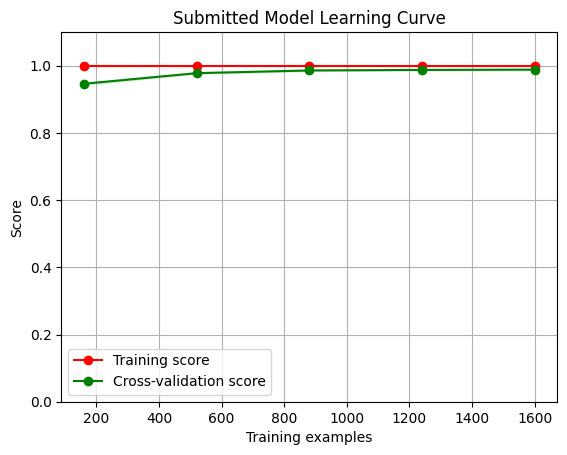

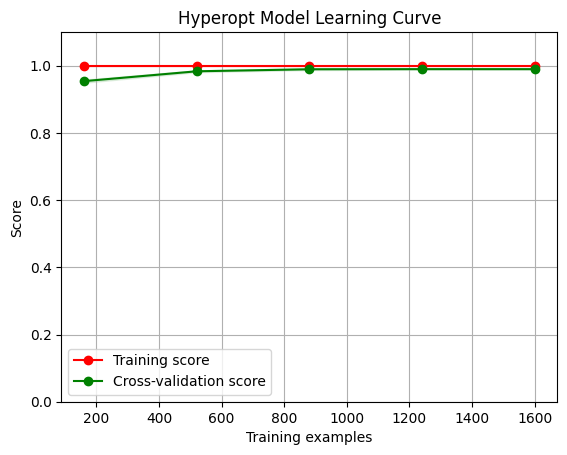

In [17]:
# Optimization function for Hyperopt
def optimize_hyperopt(params, x, y):
    entropy = params["criterion"]
    n_estimators = int(params["n_estimators"])
    max_depth = int(params["max_depth"])
    max_features = params["max_features"]

    model = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        criterion=entropy
    )
    kf = model_selection.StratifiedKFold(n_splits=5)
    roc_aucs = []

    for train_idx, test_idx in kf.split(X=x, y=y):
        xtrain = x[train_idx]
        ytrain = y[train_idx]
        xtest = x[test_idx]
        ytest = y[test_idx]

        model.fit(xtrain, ytrain)
        preds = model.predict_proba(xtest)
        fold_roc_auc = metrics.roc_auc_score(ytest, preds, multi_class='ovr')
        roc_aucs.append(fold_roc_auc)

    return {"loss": -1.0 * np.mean(roc_aucs), "status": STATUS_OK}

if __name__ == "__main__":
    df = pd.read_csv("/content/mobile_train.csv")
    print("Columns in the dataset:", df.columns)
    X = df.drop("price_range", axis=1).values
    Y = df["price_range"].values

    param_space = {
        "criterion": hp.choice("criterion", ["gini", "entropy"]),
        "n_estimators": hp.quniform("n_estimators", 100, 1500, 1),
        "max_depth": hp.quniform("max_depth", 3, 15, 1),
        "max_features": hp.uniform("max_features", 0.01, 1.0)
    }

    optimization_function = partial(optimize_hyperopt, x=X, y=Y)

    trials = Trials()
    result = fmin(
        fn=optimization_function,
        space=param_space,
        algo=tpe.suggest,
        max_evals=20,
        trials=trials
    )

    best_params = {
        "criterion": ["gini", "entropy"][result["criterion"]],
        "n_estimators": int(result["n_estimators"]),
        "max_depth": int(result["max_depth"]),
        "max_features": result["max_features"]
    }

    print("Best Parameters from Hyperopt:", best_params)

    # Create models
    random_model = ensemble.RandomForestClassifier()
    submitted_model = ensemble.RandomForestClassifier(
        n_estimators=500, max_depth=10, max_features=0.5, criterion='gini'
    )
    hyperopt_model = ensemble.RandomForestClassifier(**best_params)

    # Plot learning curves
    plot_learning_curve(random_model, X, Y, title="Random Model Learning Curve")
    plot_learning_curve(submitted_model, X, Y, title="Submitted Model Learning Curve")
    plot_learning_curve(hyperopt_model, X, Y, title="Hyperopt Model Learning Curve")

    plt.show()


# CMA-ES

> Covariance Matrix Adaptation Evolution Strategy



In [19]:
!pip install cma

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 4.6 MB/s eta 0:00:00


In [26]:
import pandas as pd
import numpy as np
from sklearn import ensemble, metrics, model_selection
import cma
import matplotlib.pyplot as plt

# Utility function to plot learning curve
def plot_learning_curve(estimator, X, y, title="Learning Curve", cv=5, n_jobs=-1):
    train_sizes, train_scores, test_scores = model_selection.learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, scoring="roc_auc_ovr"
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)

    plt.grid()

    plt.fill_between(
        train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r"
    )
    plt.fill_between(
        train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g"
    )

    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

# Objective function for CMA-ES
def optimize_cmaes(params, x, y):
    n_estimators = int(params[0])
    max_depth = int(params[1])
    max_features = params[2]
    criterion = "gini" if params[3] < 0.5 else "entropy"

    model = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        criterion=criterion
    )
    kf = model_selection.StratifiedKFold(n_splits=5)
    roc_aucs = []

    for train_idx, test_idx in kf.split(X=x, y=y):
        xtrain, xtest = x[train_idx], x[test_idx]
        ytrain, ytest = y[train_idx], y[test_idx]

        model.fit(xtrain, ytrain)
        preds = model.predict_proba(xtest)
        fold_roc_auc = metrics.roc_auc_score(ytest, preds, multi_class='ovr')
        roc_aucs.append(fold_roc_auc)

    return -1.0 * np.mean(roc_aucs)  # CMA-ES minimizes, so return negative ROC AUC

if __name__ == "__main__":
    # Load data
    df = pd.read_csv("/content/mobile_train.csv")
    print("Columns in the dataset:", df.columns)
    X = df.drop("price_range", axis=1).values
    Y = df["price_range"].values

    # Define initial parameters and bounds
    initial_params = [500, 10, 0.5, 0]  # n_estimators, max_depth, max_features, criterion (0: gini, 1: entropy)
    lower_bounds = [100, 3, 0.01, 0]
    upper_bounds = [1500, 15, 1.0, 1]
    bounds = [lower_bounds, upper_bounds]

    # Run CMA-ES optimization
    es = cma.CMAEvolutionStrategy(initial_params, 0.5, {'bounds': bounds, 'popsize': 20})
    while not es.stop():
        solutions = es.ask()
        scores = [optimize_cmaes(s, x=X, y=Y) for s in solutions]
        es.tell(solutions, scores)

    # Best solution
    best_params = es.result.xbest
    print("Best Parameters from CMA-ES:", best_params)

    # Translate parameters
    best_params_dict = {
        "n_estimators": int(best_params[0]),
        "max_depth": int(best_params[1]),
        "max_features": best_params[2],
        "criterion": "gini" if best_params[3] < 0.5 else "entropy"
    }
    print("Translated Best Parameters:", best_params_dict)

    # Create models
    random_model = ensemble.RandomForestClassifier()
    submitted_model = ensemble.RandomForestClassifier(
        n_estimators=500, max_depth=10, max_features=0.5, criterion='gini'
    )
    cmaes_model = ensemble.RandomForestClassifier(**best_params_dict)

    # Plot learning curves
    plot_learning_curve(random_model, X, Y, title="Random Model Learning Curve")
    plot_learning_curve(submitted_model, X, Y, title="Submitted Model Learning Curve")
    plot_learning_curve(cmaes_model, X, Y, title="CMA-ES Optimized Model Learning Curve")


Columns in the dataset: Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi', 'price_range'],
      dtype='object')
(10_w,20)-aCMA-ES (mu_w=5.9,w_1=27%) in dimension 4 (seed=804684, Mon Jun 17 14:55:17 2024)


/usr/local/lib/python3.10/dist-packages/cma/evolution_strategy.py:1901: UserWarning: Sampling standard deviation i=2 at iteration 0 change by 0.6599835002062482 to stds[2]=0.32999999999999996
  warnings.warn("Sampling standard deviation i={} at iteration {}"
/usr/local/lib/python3.10/dist-packages/cma/evolution_strategy.py:1901: UserWarning: Sampling standard deviation i=3 at iteration 0 change by 0.6666416671354108 to stds[3]=0.3333333333333333
  warnings.warn("Sampling standard deviation i={} at iteration {}"


KeyboardInterrupt: 

# Additional :

> Keras Hyperparameter Tuning

> Genetic Algorithm (TPOT Classifier)

> BOTorch





TPOT Classifier

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
df=pd.read_csv('/content/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
import numpy as np
df['Glucose']=np.where(df['Glucose']==0,df['Glucose'].median(),df['Glucose'])
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72,35,0,33.6,0.627,50,1
1,1,85.0,66,29,0,26.6,0.351,31,0
2,8,183.0,64,0,0,23.3,0.672,32,1
3,1,89.0,66,23,94,28.1,0.167,21,0
4,0,137.0,40,35,168,43.1,2.288,33,1


In [4]:

X=df.drop('Outcome',axis=1)
y=df['Outcome']

In [5]:
pd.DataFrame(X,columns=df.columns[:-1])

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148.0,72,35,0,33.6,0.627,50
1,1,85.0,66,29,0,26.6,0.351,31
2,8,183.0,64,0,0,23.3,0.672,32
3,1,89.0,66,23,94,28.1,0.167,21
4,0,137.0,40,35,168,43.1,2.288,33
...,...,...,...,...,...,...,...,...
763,10,101.0,76,48,180,32.9,0.171,63
764,2,122.0,70,27,0,36.8,0.340,27
765,5,121.0,72,23,112,26.2,0.245,30
766,1,126.0,60,0,0,30.1,0.349,47


In [6]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=0)

In [7]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier=RandomForestClassifier(n_estimators=10).fit(X_train,y_train)
prediction=rf_classifier.predict(X_test)

In [8]:
y.value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [9]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
print(confusion_matrix(y_test,prediction))
print(accuracy_score(y_test,prediction))
print(classification_report(y_test,prediction))

[[92 15]
 [19 28]]
0.7792207792207793
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       107
           1       0.65      0.60      0.62        47

    accuracy                           0.78       154
   macro avg       0.74      0.73      0.73       154
weighted avg       0.77      0.78      0.78       154



In [10]:
# Manual Hyperparameter Tuning
model=RandomForestClassifier(n_estimators=300,criterion='entropy',
                             max_features='sqrt',min_samples_leaf=10,random_state=100).fit(X_train,y_train)
predictions=model.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(accuracy_score(y_test,predictions))
print(classification_report(y_test,predictions))

[[98  9]
 [18 29]]
0.8246753246753247
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       107
           1       0.76      0.62      0.68        47

    accuracy                           0.82       154
   macro avg       0.80      0.77      0.78       154
weighted avg       0.82      0.82      0.82       154



In [11]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 1000,10)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,14]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,6,8]
# Create the random grid
param = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'criterion':['entropy','gini']}
print(param)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000], 'min_samples_split': [2, 5, 10, 14], 'min_samples_leaf': [1, 2, 4, 6, 8], 'criterion': ['entropy', 'gini']}


In [12]:
!pip install tpot

  Using cached scikit_learn-1.5.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.3 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.1.3
    Uninstalling scikit-learn-1.1.3:
      Successfully uninstalled scikit-learn-1.1.3


In [13]:
pip install tpot --upgrade


In [14]:
!pip install scikit-learn==1.1.3


  Using cached scikit_learn-1.1.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (30.5 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.0
    Uninstalling scikit-learn-1.5.0:
      Successfully uninstalled scikit-learn-1.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tpot 0.12.2 requires scikit-learn>=1.4.1, but you have scikit-learn 1.1.3 which is incompatible.
bigframes 1.8.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.


In [15]:
pip uninstall scikit-learn tpot
pip install scikit-learn==1.1.3 tpot


SyntaxError: invalid syntax (<ipython-input-15-d4d51ef2da03>, line 1)

In [16]:
from tpot import TPOTClassifier



In [18]:

tpot_classifier = TPOTClassifier(generations= 5, population_size= 24, offspring_size= 12,
                                 verbosity= 2, early_stop= 12,
                                 config_dict={'sklearn.ensemble.RandomForestClassifier': param},
                                 cv = 4, scoring = 'accuracy')
tpot_classifier.fit(X_train,y_train)

Optimization Progress:   0%|          | 0/84 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -inf


RuntimeError: There was an error in the TPOT optimization process. This could be because the data was not formatted properly, because a timeout was reached or because data for a regression problem was provided to the TPOTClassifier object. Please make sure you passed the data to TPOT correctly. If you enabled PyTorch estimators, please check the data requirements in the online documentation: https://epistasislab.github.io/tpot/using/

In [ ]:
accuracy = tpot_classifier.score(X_test, y_test)
print(accuracy)